# Mnist digit recognition using a number of modelling approaches

The code uses built in keras.datasets.mnist functionality which automatically preloads all the necessary data for neural net training. Otherwise one needs to download the files and convert into numpy arrays self.

## Results
The models have the following best accuracy:
* CNN: 99.26%
* Random Forest: 96.01%
* Gradient Boosted Tree: 84.61% (this possibly can be improved)
* OneVsRest Support Vector Machine: 40.45% (this very likely could be improved, but training takes a very long time therefore I skipped tuning of the model/preprocessing)
* Ridge Logistic Regression: 92.55%

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.metrics as sm

from keras.datasets import mnist

import psutil
core_count = psutil.cpu_count()
print(f"VM has {core_count} cores, and {psutil.virtual_memory().free/1000000:.2f}MB free RAM (out of {psutil.virtual_memory().total/1000000:.2f} MB total), and {psutil.disk_usage('/').free/1000000:.2f}MB free Disk Space (out of {psutil.disk_usage('/').total/1000000:.2f} MB total)")

Using TensorFlow backend.


VM has 2 cores, and 11343.09MB free RAM (out of 13655.32 MB total), and 343690.44MB free Disk Space (out of 384691.15 MB total)


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(f'GPU device not found {device_name}')
else:
  print(f'Found GPU at: {device_name}')
  
# alternatively
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

Found GPU at: /device:GPU:0


## Data loading and visualisation

Load data and understand the structure of it, as well as display some examples as images.

In [4]:
# This call downloads the data from https://s3.amazonaws.com/img-datasets/mnist.npz
# and reads it as a numpy ndarray. It should be fairly easy to write such code, and thus use a different dataset.
# Note: .npz file extensinon is a numpy matrix file created by np.savez. If one would use any other type of dataset
# one would have to obviously download the file and load it manually into numpy arrays.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_classes = np.bincount(np.append(y_train, y_test)).size

print(f"Total number of classes in the complete data set is {num_classes}")

11493376/11490434 [==============================] - 1s 0us/step
Total number of classes in the complete data set is 10


In [5]:
# look at the shape and type of the data
describeNumpyArray = lambda name, ar: print(f"{name}: {type(ar)} of {type(ar.flatten()[0])}, with shape {ar.shape}")

describeNumpyArray('x_train', x_train)
describeNumpyArray('y_train', y_train)
describeNumpyArray('x_test', x_test)
describeNumpyArray('y_test', y_test)

x_train: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (60000, 28, 28)
y_train: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (60000,)
x_test: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (10000, 28, 28)
y_test: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (10000,)


Text(0.5, 1.0, 'Image of digit 5')

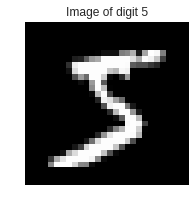

In [8]:
# example of single plot
plt.figure(figsize=(3,3))
plt.grid(False)
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Image of digit {y_train[0]}")

In [0]:
def plotImagesByIndex(indexes, x_set, y_set, y_pred = None, suptitle = None):
  image_columns = 8
  image_rows = int(np.ceil(len(indexes)/image_columns))

  fig, m_axs = plt.subplots(image_rows, image_columns, figsize = (image_columns*3, image_rows*3))
  if suptitle is not None:
    fig.suptitle(suptitle, fontsize=18)
  for i in range(0, len(indexes)):
    current_row = int(np.floor(i/image_columns))
    current_column = i%image_columns
    m = m_axs[current_row][current_column]
    m.imshow(x_set[indexes[i]], cmap='gray')
    m.grid(False)
    m.axis('off')
    if y_pred is None:
      m.set_title(f"Label: {y_set[indexes[i]]}")
    else:
      m.set_title(f"Label: {y_set[indexes[i]]}, pred: {y_pred[indexes[i]]}")

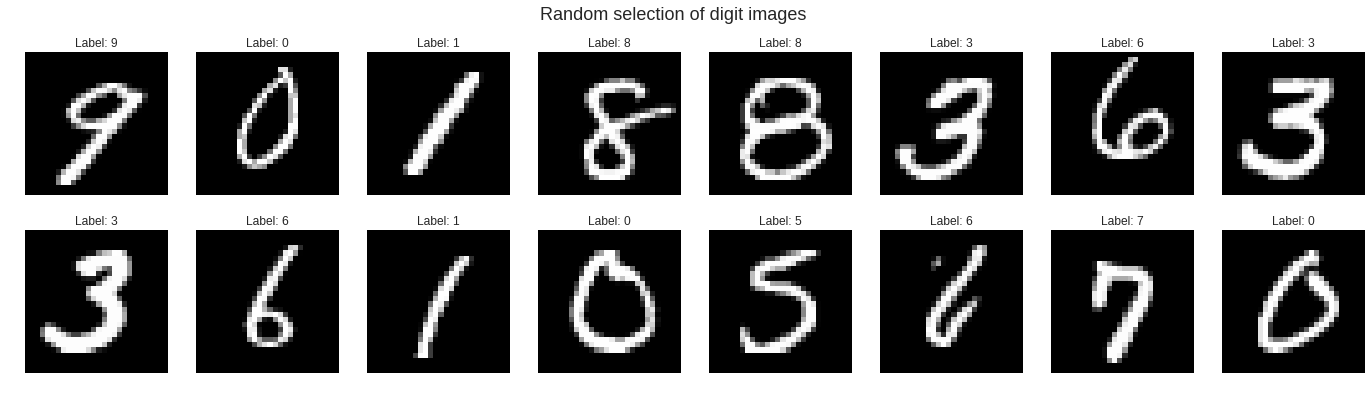

In [7]:
# Plot the digits
sample_size = 16
sample_indexes = np.random.choice(len(x_train), size=sample_size, replace=False)

plotImagesByIndex(sample_indexes, x_train, y_train, suptitle = 'Random selection of digit images')

In [0]:
import seaborn as sns

def plotConfusionMatrixAndRocCurve(model_name, y_onehot_set, pred_prob_set, y_set, pred_set):
  ##### ROC Curves
  # compute per-class ROC curves
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
      fpr[i], tpr[i], _ = sm.roc_curve(y_onehot_set[:, i], pred_prob_set[:, i])
      roc_auc[i] = sm.auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = sm.roc_curve(y_onehot_set.ravel(), pred_prob_set.ravel())
  roc_auc["micro"] = sm.auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve
  fig, m_axs = plt.subplots(1, 2, figsize = (12, 5))
  m_axs[0].plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC ({roc_auc["micro"]:0.2f})')
  for i in range(num_classes):
      m_axs[0].plot(fpr[i], tpr[i], label=f'ROC {i} (area = {roc_auc[i]:0.2f})')

  m_axs[0].plot([0, 1], [0, 1], 'k--')
  m_axs[0].set_xlim([0.0, 1.0])
  m_axs[0].set_ylim([0.0, 1.05])
  m_axs[0].set_xlabel('False Positive Rate')
  m_axs[0].set_ylabel('True Positive Rate')
  m_axs[0].set_title('ROC curves for each class in the multi-class classifier')
  m_axs[0].legend(loc="lower right")

  ##### Header title
  accuracy = sm.accuracy_score(y_set, pred_set)
  # precision = sm.precision_score(y_set, pred_set, average = 'weighted')
  # recall = sm.recall_score(y_set, pred_set, average = 'weighted')
  
  fig.suptitle(f"{model_name}, accuracy: {accuracy:0.4f}", fontsize=18)
  
  ##### Confusion Marix
  confusion_matrix = sm.confusion_matrix(y_set, pred_set)
  
  # Remember you can just print it, no need for the advanced plotting :)
  # print(f'Test accuracy: {accuracy_lr}')
  # print(f'Test confusion matrix: \n{confusion_matrix_lr}')

  class_names=list(range(0,num_classes)) # name  of classes
  tick_marks = np.arange(len(class_names))
  m_axs[1].set_xticks(tick_marks, class_names)
  m_axs[1].set_yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  m_axs[1].xaxis.set_label_position("bottom")
  m_axs[1].set_title('Confusion matrix', y=1.2)
  m_axs[1].set_ylabel('Actual label')
  m_axs[1].set_xlabel('Predicted label')

In [0]:
def plotConfusionMatrixRocCurveAndimages(model_name, y_onehot_set, pred_prob_set, y_set, pred_set, x_set):
  plotConfusionMatrixAndRocCurve(model_name, y_onehot_set, pred_prob_set, y_set, pred_set)
  
  misclasified_indexes = np.where((y_set != pred_set))[0]
  clasified_indexes = np.where((y_set == pred_set))[0]
  sample_size = 16
  
  plotImagesByIndex(clasified_indexes[np.random.choice(len(clasified_indexes), size=sample_size, replace=False)], x_set, y_set, pred_set, suptitle = f'{model_name}: correctly classified images')
  plotImagesByIndex(misclasified_indexes[np.random.choice(len(misclasified_indexes), size=sample_size, replace=False)], x_set, y_set, pred_set, suptitle = f'{model_name}: misclassified images')

 ## CNN approach

In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

### Data preprocessing

In [0]:
batch_size = 128
epochs = 10 # it already gets very good results after 10 epohs (> 99% accuracy on the train set), but normally one has more then 10. Originallt the value was 120

In [0]:
img_rows, img_cols = 28, 28

#### reshaping the data with accordance on the Keras' needs

As Keras takes images with n channels, and these are greyscale images (no channel array), one has to add array with channels which in this case will be of length 1 (single channel per pixel).

In [13]:
print(f"K.image_data_format() = {K.image_data_format()}")
if K.image_data_format() == 'channels_first':
    x_train_k = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_k = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_k = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_k = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# convert to float32
x_train_k = x_train_k.astype('float32') 
x_test_k = x_test_k.astype('float32')

# normalize to one
x_train_k /= 255
x_test_k /= 255

K.image_data_format() = channels_last


In [14]:
describeNumpyArray('x_train_k', x_train_k)
describeNumpyArray('x_test_k', x_test_k)

x_train_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (60000, 28, 28, 1)
x_test_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 28, 28, 1)


#### applying One Hot encoding to the output labels
[Wiki One-Hot Encoder](https://en.wikipedia.org/wiki/One-hot)

Converts a single labelled column into a vector of true/false columns saying true/false for each of the possibilities.

Example of encoding
* possible values: 'red', 'green', 'yellow'
* example column: ['green', 'red', 'green', 'yellow']

Is encoded into:
* [[0 ,1, 0], [1 ,0, 0], [0 ,1, 0], [0, 0, 1]]

##### Note:
Some One-hot encoders could encode it into:
* [[0 ,1], [1 ,0], [0 ,1], [0, 0]]
with 'yellow' is encoded into [0,0], but not this one.

Note that traditional class in scikitlearn is [label_binarize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html#sklearn.preprocessing.label_binarize), but Keras library has it's own implementation


In [0]:
# One hot encoding
y_train_k = keras.utils.to_categorical(y_train, num_classes)
y_test_k = keras.utils.to_categorical(y_test, num_classes)

In [16]:
describeNumpyArray('y_train_k', y_train_k)
describeNumpyArray('y_test_k', y_test_k)

y_train_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (60000, 10)
y_test_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 10)


In [17]:
# just to visualize the output vectors after one hot encoding
y_train_k_df = pd.DataFrame(y_train_k[0:8])
y_train_k_df["OriginalLabel"] = y_train[y_train_k_df.index]
y_train_k_df

,0,1,2,3,4,5,6,7,8,9,OriginalLabel
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3


### Creating the CNN

In [0]:
model = Sequential()

In [0]:
import tensorflow as tf 

#### adding layers to the CNN

Layer types:

* The Convolution2D layers operate on 2D matrices so we input the digit images directly to the model.
* The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
* The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

Read more:
* [CNN Wiki](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [Relu Activation Function - Wiki](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
* [CNN Keras](https://keras.io/layers/convolutional/)
* [Pooling Keras](https://keras.io/layers/pooling/)

In [20]:
# Model V1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))

# # Model V2
# nb_classes = 10
# model.add(Conv2D(nb_filters, kernel_size=(3,3), padding='valid', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(Conv2D(nb_filters, kernel_size))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(units=128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=nb_classes))
# model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


#### compiling the model

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1982592   
__________

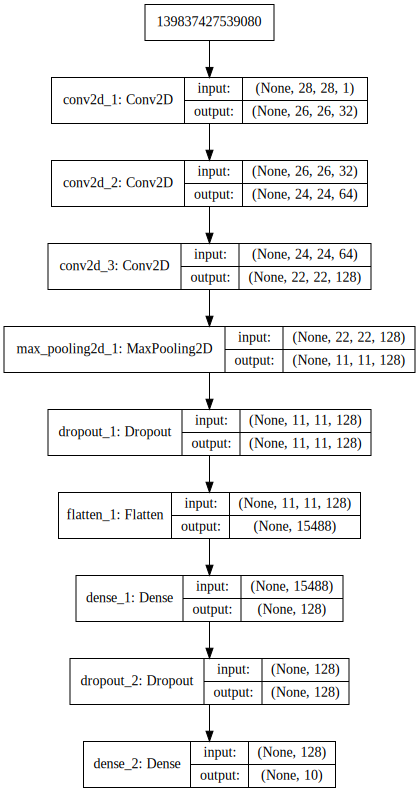

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

#### training the model

In [23]:
# carefully, this takes a lot of time
history = model.fit(x_train_k, y_train_k,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_k, y_test_k))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.2396 - acc: 0.9270 - val_loss: 0.0503 - val_acc: 0.9848
Epoch 2/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0754 - acc: 0.9776 - val_loss: 0.0298 - val_acc: 0.9892
Epoch 3/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0563 - acc: 0.9834 - val_loss: 0.0281 - val_acc: 0.9902
Epoch 4/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0457 - acc: 0.9861 - val_loss: 0.0263 - val_acc: 0.9915
Epoch 5/10
60000/60000 [==============================] - 17s 281us/step - loss: 0.0378 - acc: 0.9890 - val_loss: 0.0318 - val_acc: 0.9899
Epoch 6/10
60000/60000 [==============================] - 17s 281us/step - loss: 0.0335 - acc: 0.9903 - val_loss: 0.0240 - val_acc: 0.9918
Epoch 7/10
60000/60000 [==============================] - 17s 280us/step - loss: 0.0286 - acc: 0.9913 - val_loss: 0.

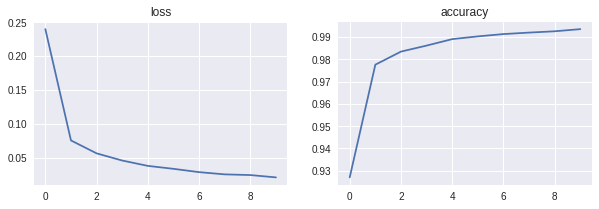

In [24]:
fig, m_axs = plt.subplots(1, 2, figsize = (10, 3))

m_axs[0].plot(history.epoch,history.history['loss'])
m_axs[0].set_title('loss')
m_axs[1].plot(history.epoch,history.history['acc'])
m_axs[1].set_title('accuracy');

#### evaulating and viewing the result

In [0]:
pred_prob = model.predict(x_test_k, verbose=0)
# as predictions are probabilities from 0 to 1 (but rarely exactly these values) one must apply decision threshold
# np.round applies a decision threshold at 0.5
pred_classified = np.round(pred_prob)

# reverse One-Hot encoder. Note that it is not always that trivial :)
# it only works this time because the index of the column is the same as the value before the encoding
# in normal cases one has to train One-Hot encoder and the reverse it
pred = np.argmax(pred_classified, axis=1)

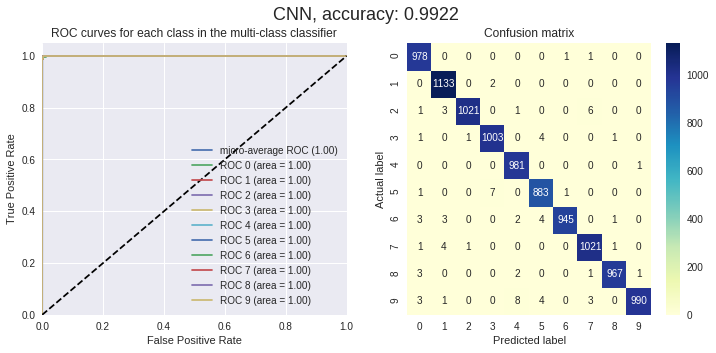

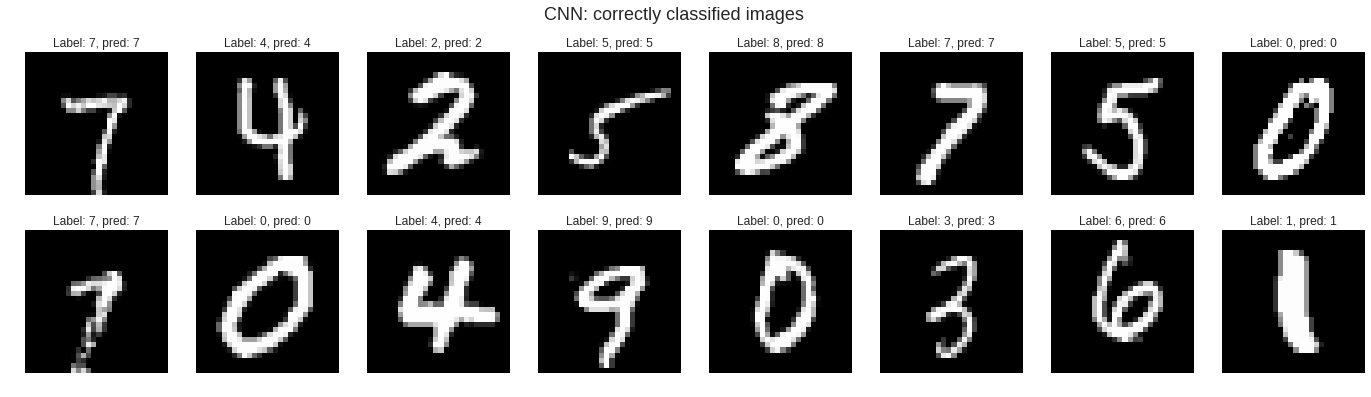

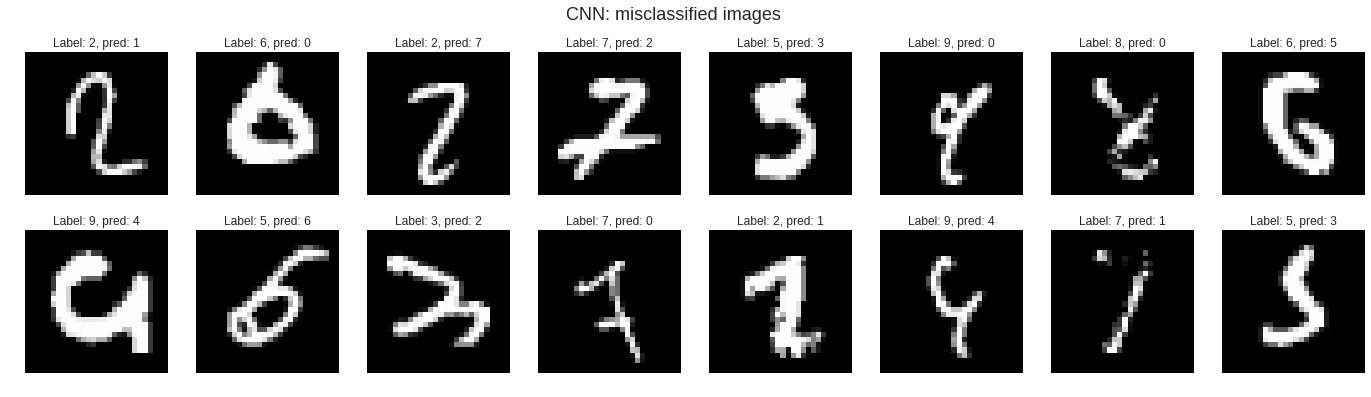

In [26]:
# score = model.evaluate(x_test_k, y_test_k, verbose=0)
# print(f'Test loss: {score[0]: 0.4f}')
# print(f'Test accuracy: {score[1]: 0.4f}')
plotConfusionMatrixRocCurveAndimages('CNN', y_test_k, pred_prob, y_test, pred, x_test)

## Random Forest approach

### Data Preprocessing

Model requires 2D matrix, wiht each row being a single image/observation

In [0]:
x_train_flat = x_train.reshape(60000, 28*28)
x_test_flat = x_test.reshape(10000, 28*28)

In [28]:
image_a = x_train[0].reshape(28*28)
image_b = x_train_flat[0]
are_equal = np.array_equal(image_a, image_b)
print(f"Are images before and after transformation the same: {are_equal}")

Are images before and after transformation the same: True


In [29]:
describeNumpyArray('x_train', x_train)
describeNumpyArray('x_train_flat', x_train_flat)
describeNumpyArray('x_test', x_test)
describeNumpyArray('x_test_flat', x_test_flat)

x_train: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (60000, 28, 28)
x_train_flat: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (60000, 784)
x_test: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (10000, 28, 28)
x_test_flat: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (10000, 784)


### Creating the RandomForrestClassifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
model_rf = RandomForestClassifier(n_jobs = core_count, verbose = True, n_estimators = 20)

In [32]:
model_rf.fit(x_train_flat, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   11.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=2,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [33]:
print(f"Number of trees is {len(model_rf)} and number of nodes per tree is {list(map(lambda a: a.tree_.node_count, model_rf))}")
# display(model_rf.estimators_)

Number of trees is 20 and number of nodes per tree is [10039, 9787, 10063, 9967, 10191, 9989, 10117, 9995, 10171, 10019, 9991, 10307, 10003, 9809, 9877, 10133, 9911, 9751, 9633, 9745]


In [34]:
pred_rf = model_rf.predict(x_test_flat)
pred_prob_rf = model_rf.predict_proba(x_test_flat)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished


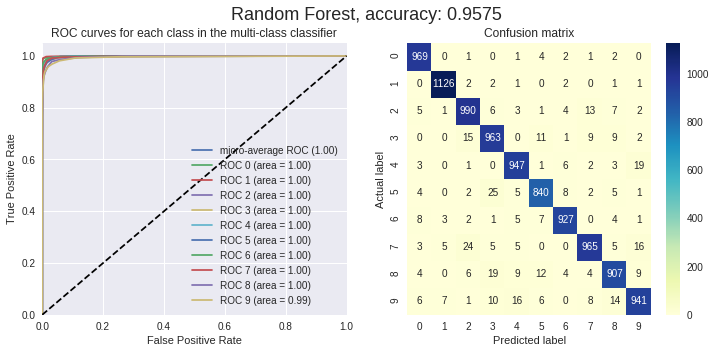

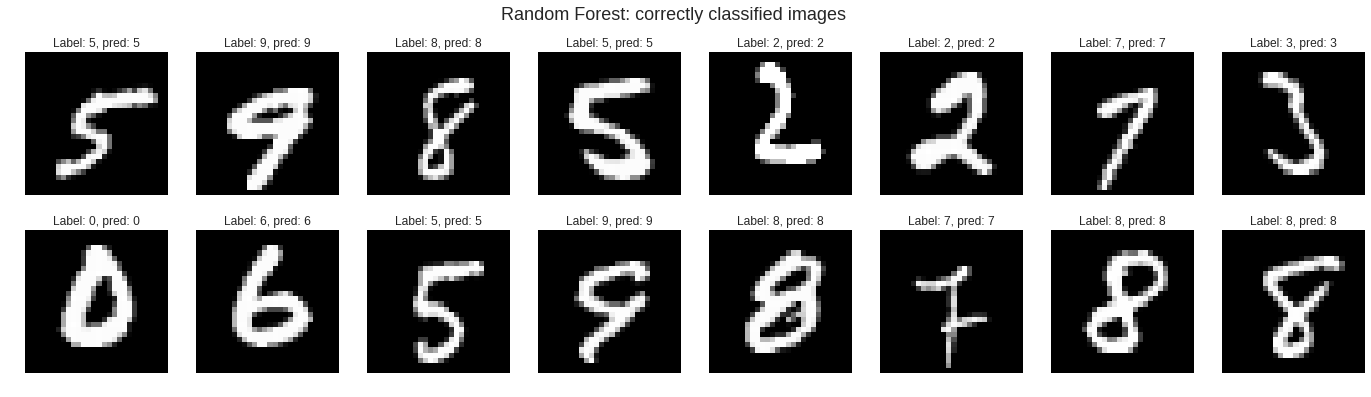

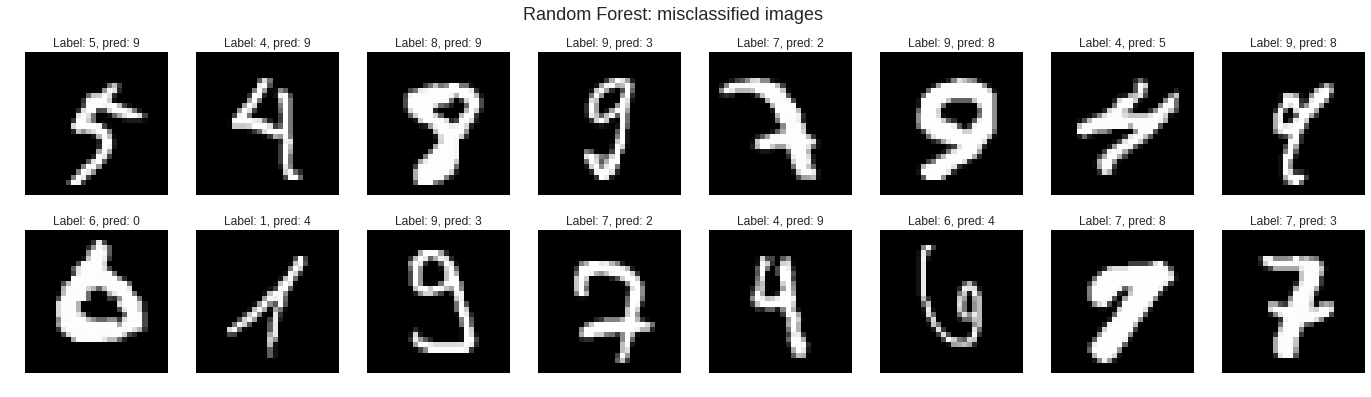

In [35]:
plotConfusionMatrixRocCurveAndimages('Random Forest', y_test_k, pred_prob_rf, y_test, pred_rf, x_test)

## Gradient Boosted Tree classifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
model_gbt = GradientBoostingClassifier(verbose = True, n_estimators = 10)

In [38]:
model_gbt.fit(x_train_flat, y_train)

      Iter       Train Loss   Remaining Time 
         1      114861.2351            6.19m
         2      101162.6134            5.49m
         3       91021.4627            4.80m
         4       83195.2972            4.11m
         5       76081.9456            3.42m
         6       70264.7887            2.73m
         7       65163.6136            2.05m
         8       60796.0857            1.36m
         9       56783.8175           40.89s
        10       53191.0278            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [39]:
print(f"Number of trees {len(model_gbt.estimators_)} and number of nodes per tree is {list(map(lambda a: np.sum(list(map(lambda t:t.tree_.node_count, a.flatten()))), model_gbt.estimators_))}")
# display(model_gbt.estimators_)

Number of trees 10 and number of nodes per tree is [150, 150, 150, 150, 150, 150, 150, 150, 150, 150]


In [0]:
pred_gbt = model_gbt.predict(x_test_flat)
pred_prob_gbt = model_gbt.predict_proba(x_test_flat)

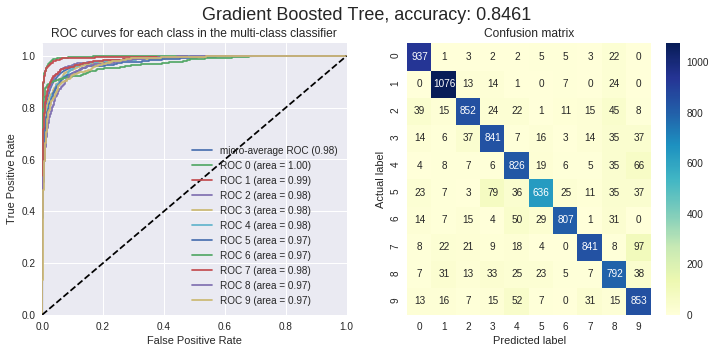

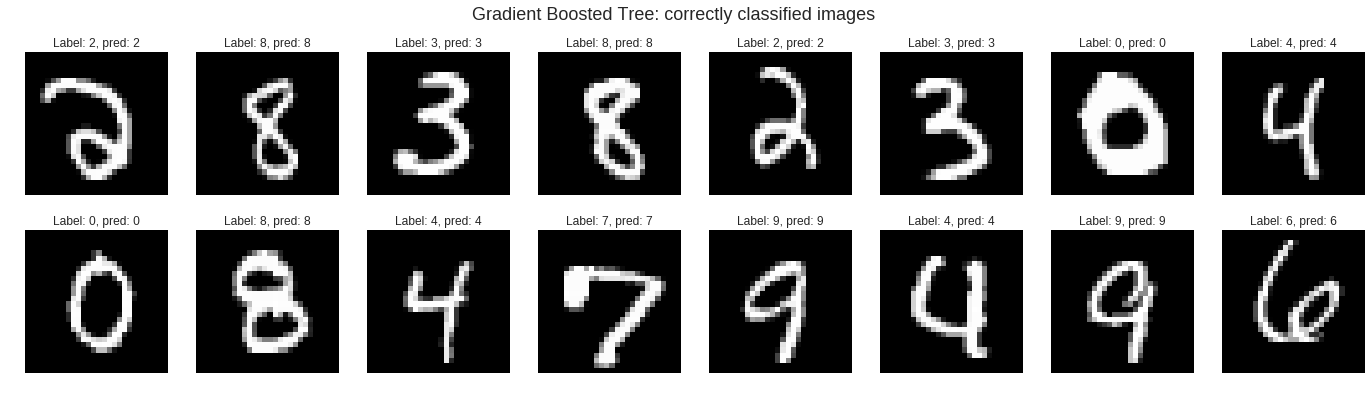

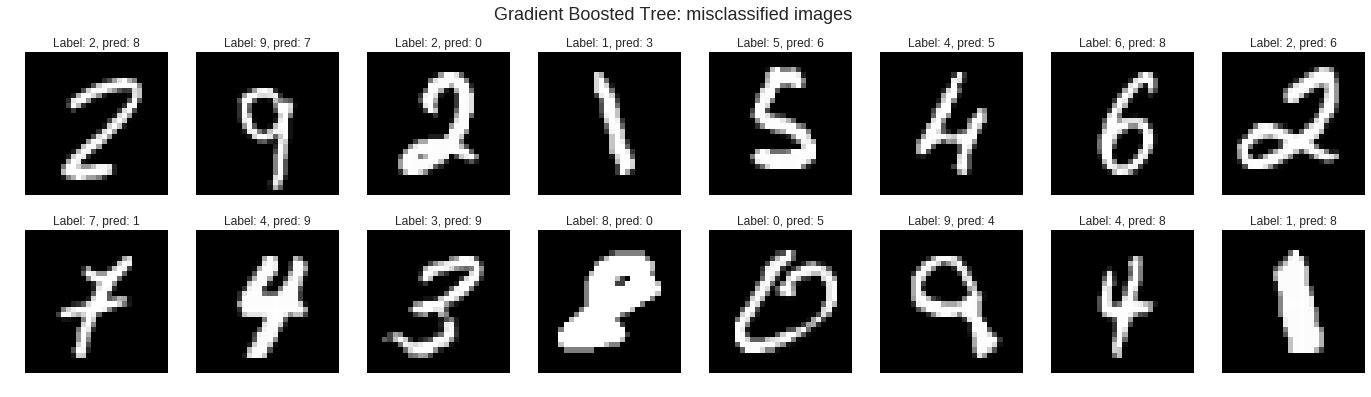

In [41]:
plotConfusionMatrixRocCurveAndimages('Gradient Boosted Tree', y_test_k, pred_prob_gbt, y_test, pred_gbt, x_test)

## Support Vector Machine classifier approach

### Data Preprocessing

In [0]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [43]:
# Model requires one hot encoded data, normally can use label_binarize, but in this case the data is already endoed for keras in variables: y_train_k and y_test_k
describeNumpyArray('y_train_k', y_train_k)
describeNumpyArray('y_test_k', y_test_k)

y_train_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (60000, 10)
y_test_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 10)


Text(0.5, 1.0, 'Variance transformation')

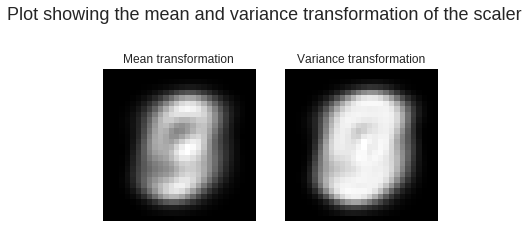

In [44]:
# Model does not work well with unscaled data (contrary to the decision trees which do not mind htat much)
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
standart_scaler.fit(x_train_flat.astype(float))
x_train_flat_ss = standart_scaler.transform(x_train_flat.astype(float))
x_test_flat_ss = standart_scaler.transform(x_test_flat.astype(float))

# print(f"Mean (first 20 vals):\n {standart_scaler.mean_[0:20]}\nVariance (first 20 vals):\n{standart_scaler.var_[0:20]}")  

fig, m_axs = plt.subplots(1, 2, figsize = (6, 4))
fig.suptitle("Plot showing the mean and variance transformation of the scaler", fontsize=18)
m = m_axs[0]
m.imshow(standart_scaler.mean_.reshape(28,28), cmap='gray')
m.grid(False)
m.axis('off')
m.set_title("Mean transformation")
m = m_axs[1]
m.imshow(standart_scaler.var_.reshape(28,28), cmap='gray')
m.grid(False)
m.axis('off')
m.set_title("Variance transformation")

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(x_train_flat.astype(float))
x_train_flat_pca = pca.transform(x_train_flat.astype(float))
x_test_flat_pca = pca.transform(x_test_flat.astype(float)) 

print(f"Variance ratio:\n {pca.explained_variance_ratio_}\nSingular values:\n{pca.singular_values_}")  
describeNumpyArray('x_train_flat_pca', x_train_flat_pca)
describeNumpyArray('x_test_flat_pca', x_test_flat_pca)

Variance ratio:
 [0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001 0.0210919  0.02022991
 0.01715818 0.01692111 0.01578641 0.01482953 0.01324561 0.01276897
 0.01187263 0.01152684 0.01066166 0.01006713 0.00953573 0.00912544
 0.00883405 0.00839319 0.00812579 0.00786366 0.00744733 0.00690859
 0.00658094 0.00648148 0.00602615 0.00586582 0.0057002  0.00543627
 0.00505784 0.00487852 0.0048142  0.00472235 0.00456714 0.00444812
 0.00418396 0.00398183 0.00384829 0.00375003 0.00361766 0.00351436
 0.00339695 0.00319036]
Singular values:
[141291.00226882 120817.18859621 112650.9232813  105291.96728785
 100077.18497144  94183.59653123  82040.1120459   77021.85990481
  75376.92118237  69631.23338052  65869.14984994  64509.13672727
  59410.04495955  58998.19511576  56985.71130704  55231.63286149
  52198.76402516  51250.98798476  49419.4265625   48694.43400411
  46831.35272304  45506.89087616  44289.55259603  43326.24908628
  42628.89703177

### Creating of the OneVsRestClassifier

In [0]:
# Best results:
# * StandartScaler, kernel='linear', max_iter=1000, probability=False, acc: 0.4045
# * PCA(n=50), kernel='linear', max_iter = 1000, probability=False, acc: 0.2789
# * PCA(n=17), kernel='rbf', max_iter = 1000, probability=False, acc: 0.1015

x_train_flat_red = x_train_flat_ss
x_test_flat_red = x_test_flat_ss

model_svc = OneVsRestClassifier(svm.SVC(random_state=np.random.RandomState(0), verbose=True, kernel='linear', max_iter=1000, probability=False))

In [47]:
model_svc.fit(x_train_flat_red, y_train_k)

[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=1000, probability=False,
  random_state=<mtrand.RandomState object at 0x7f2e53e754c8>,
  shrinking=True, tol=0.001, verbose=True),
          n_jobs=None)

In [0]:
pred_prob_svc = model_svc.decision_function(x_test_flat_red)
pred_svc = np.argmax(pred_prob_svc, axis=1)

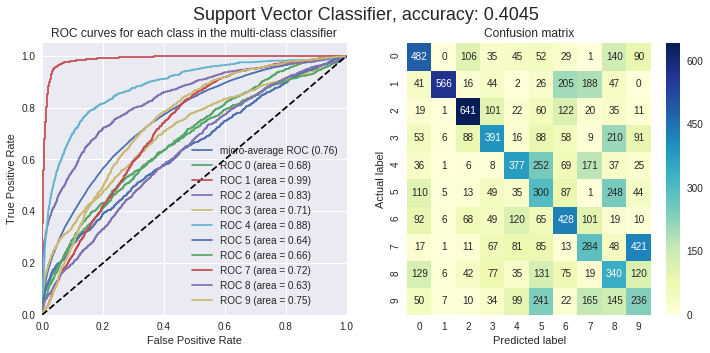

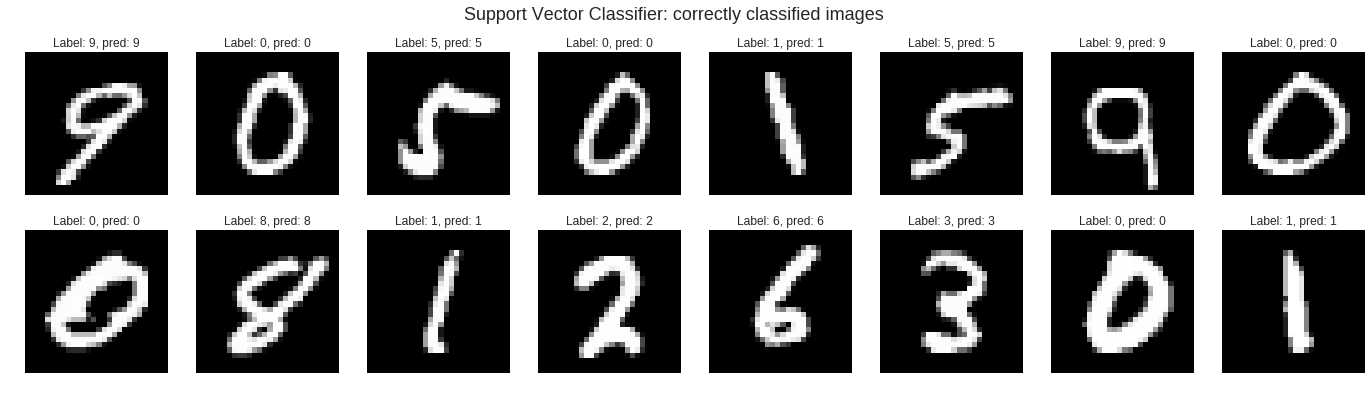

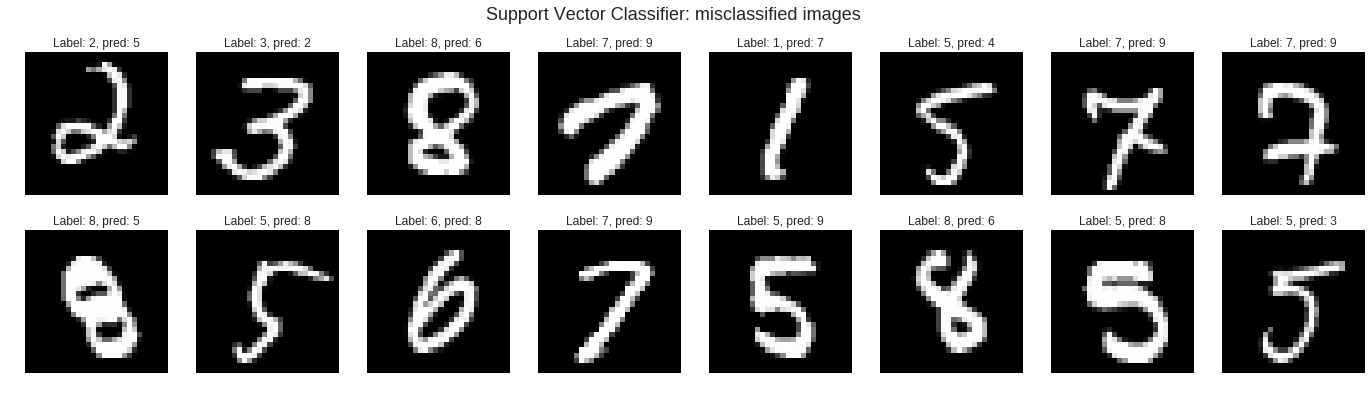

In [49]:
plotConfusionMatrixRocCurveAndimages('Support Vector Classifier', y_test_k, pred_prob_svc, y_test, pred_svc, x_test)

## Multiclass logistic regression apporach

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [0]:
# LogisticRegression, penalty='l2', solver='lbfgs', acc: 0.9255
# SGDClassifier, penalty='l2', max_iter=1000, acc: 0.8918

model_lr = LogisticRegression(random_state=np.random.RandomState(0), verbose=True, n_jobs = core_count, multi_class='multinomial', penalty='l2', solver='lbfgs')
# model_lr = SGDClassifier(random_state=np.random.RandomState(0), verbose=False, n_jobs = core_count, penalty='l2', max_iter=1000)

In [52]:
x_train_flat_red = x_train_flat
x_test_flat_red = x_test_flat

model_lr.fit(x_train_flat_red, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:  1.3min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=2, penalty='l2',
          random_state=<mtrand.RandomState object at 0x7f2e7004d360>,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False)

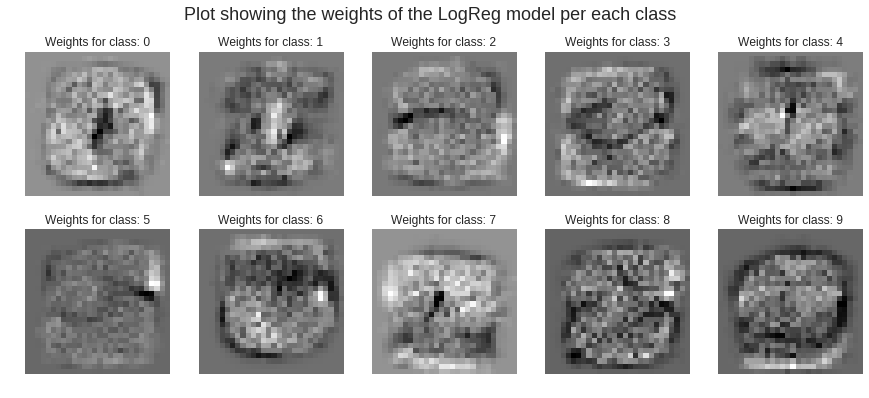

In [53]:
lr_count = model_lr.coef_.shape[0]
lr_rows = 2
lr_columns = int(lr_count/lr_rows)

fig, m_axs = plt.subplots(lr_rows, lr_columns, figsize = (lr_columns*3, lr_rows*3))
fig.suptitle("Plot showing the weights of the LogReg model per each class", fontsize=18)
for i in range(0, lr_count):
  current_row = int(np.floor(i/lr_columns))
  current_column = i%lr_columns
  m = m_axs[current_row][current_column]
  m.imshow(model_lr.coef_[i].reshape(28,28), cmap='gray')
  m.grid(False)
  m.axis('off')
  m.set_title(f"Weights for class: {i}")

In [0]:
# predict directly the labels
# pred_lr = model_lr.predict(x_test_flat_red)

# predict the probabilities first and then labels
pred_prob_lr = model_lr.predict_proba(x_test_flat_red)
pred_lr = model_lr.predict(x_test_flat_red)

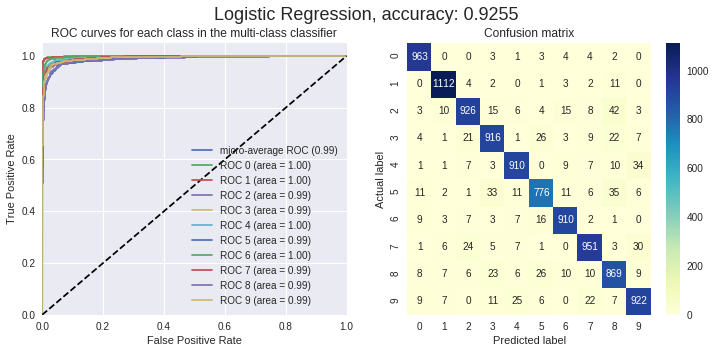

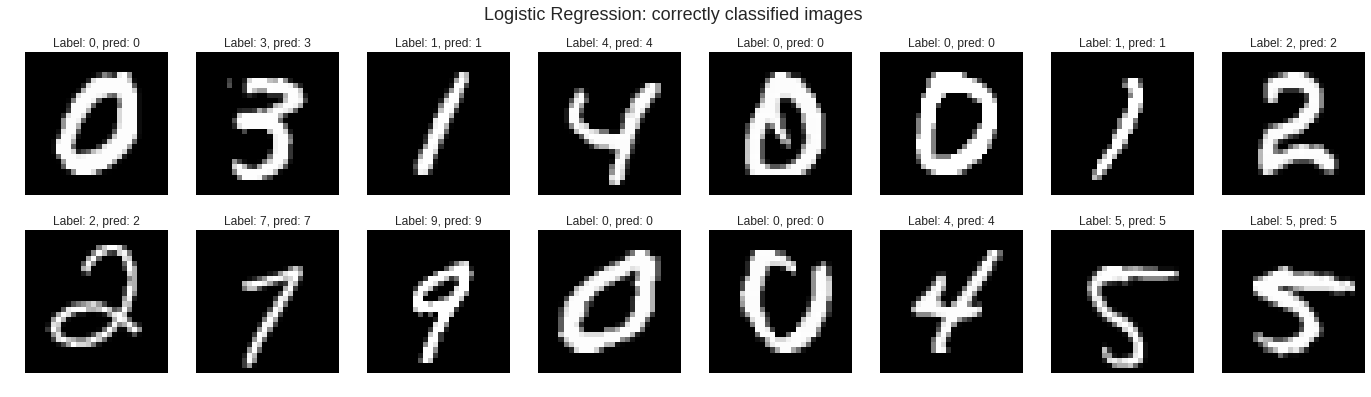

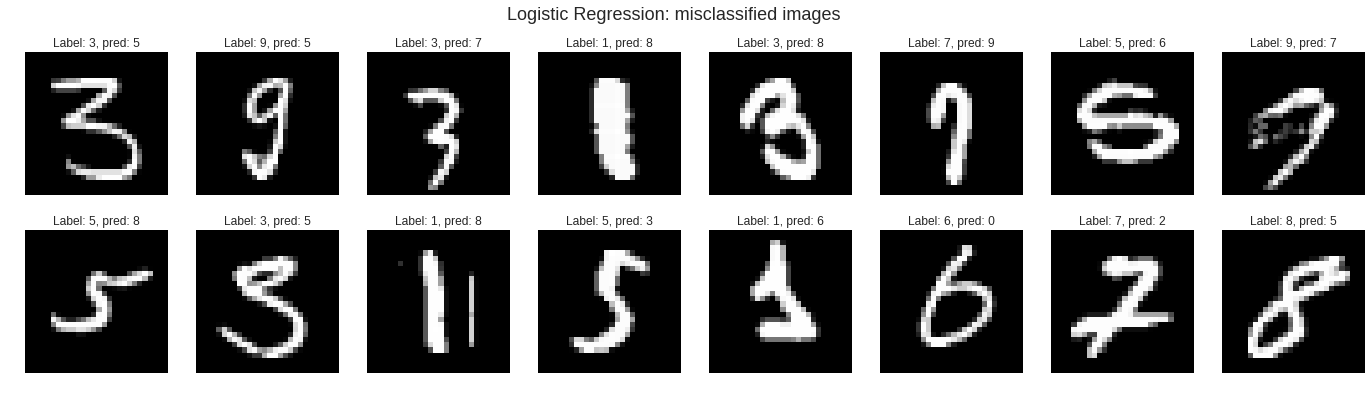

In [55]:
plotConfusionMatrixRocCurveAndimages('Logistic Regression', y_test_k, pred_prob_lr, y_test, pred_lr, x_test)